# Initialisation 

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

/Users/chanmunfai/opt/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


### Downloading of Kaggle Dataset 
If this is not your first time running this notebook, you don't have to repeat the steps from this section. 

In [ ]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [ ]:
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c pubg-finish-placement-prediction

## Pre-processsing 

Here, we will remove all missing values, convert datetime into a numeric form and extract feautures from it, convert count into a logarithmic form and drop columns 'casual' and 'registered' as these are unavailable on our test set. 

We will not have to re-run this everytime as we will save the pre-processed train file into a feather format. 

In [3]:
train = pd.read_csv("/Users/chanmunfai/fastai/courses/ml1/pubg-finish-placement-prediction/train_V2.csv", low_memory = False)

In [ ]:
test = pd.read_csv("/Users/chanmunfai/fastai/courses/ml1/pubg-finish-placement-prediction/train_V2.csv", low_memory = False)

In [ ]:
train.shape, test.shape

In [ ]:
train.head()

In [ ]:
train.dtypes

In [ ]:
train.describe()

In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

### Removing Missing Values

There are no missing values everywhere except for winPlacePerc. 

In [ ]:
display_all(train.isnull().sum().sort_index()/len(train))

In [5]:
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


This is an illegal match, so we remove it. 

In [6]:
train.drop(2744604, inplace=True)

## Running a Basic Model 

We run a model on a subset of the data first, so that we can get things running quickly. 

In [7]:
sample = 500000
df_sample = train.sample(sample)

In [8]:
df, y, nas = proc_df(df_sample, 'winPlacePerc')

Split into training and validation set 

In [9]:
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()

val_perc = 0.12 # % to use for validation set
n_valid = int(val_perc * sample) 
n_trn = len(df)-n_valid
# Split data
raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

# Check dimensions of samples
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (440000, 28) Sample target shape:  (440000,) Sample validation shape:  (60000, 28)


In [10]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error

# Function to print the MAE (Mean Absolute Error) score
# This is the metric used by Kaggle in this competition
def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid),
           'R square train:', m.score(X_train, y_train), 
           'R square val:', m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [11]:
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

['mae train: ', 0.03927727959545938, 'mae val: ', 0.06326274777288803, 'R square train:', 0.9667319298757561, 'R square val:', 0.9165303742898281]


# Feature Importance 

In [12]:
fi = rf_feat_importance(m1, X_train); fi[:10]

,cols,imp
25,walkDistance,0.307390
9,killPlace,0.254042
4,boosts,0.113732
8,heals,0.074021
26,weaponsAcquired,0.067285
13,longestKill,0.029836
20,rideDistance,0.026604
11,kills,0.019183
14,matchDuration,0.014694
5,damageDealt,0.013694


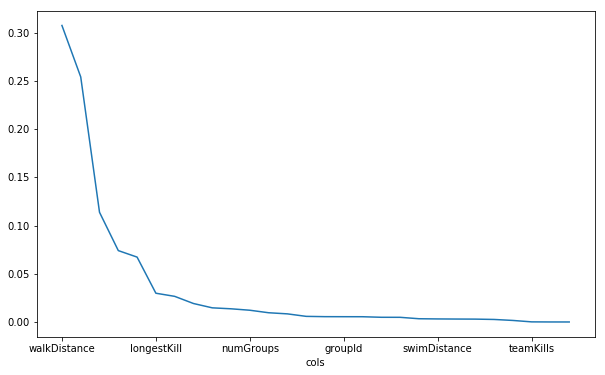

In [13]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [14]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

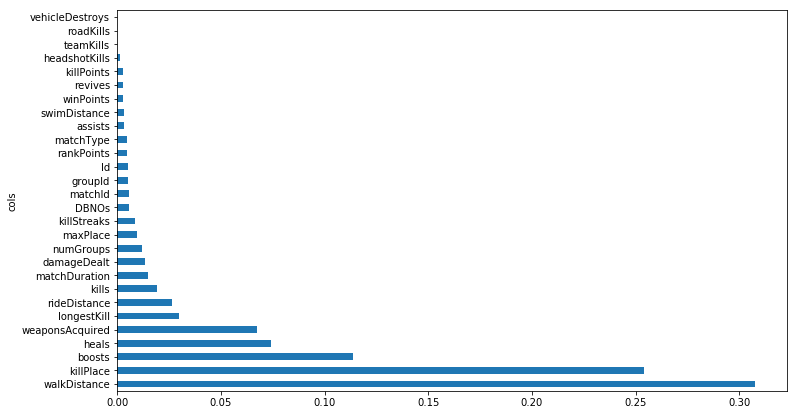

In [15]:
plot_fi(fi[:30]);

In [16]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

17

In [18]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)
X_train.shape, X_valid.shape

((440000, 17), (60000, 17))

In [21]:
m2 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features= 'sqrt',
                          n_jobs=-1, oob_score=True)
%time m2.fit(X_train, y_train)
print_score(m2)

CPU times: user 1min 8s, sys: 643 ms, total: 1min 8s
Wall time: 20 s
['mae train: ', 0.03818710746222487, 'mae val: ', 0.06266596945847182, 'R square train:', 0.9679069106703928, 'R square val:', 0.9172890567659346, 0.9141235832539647]


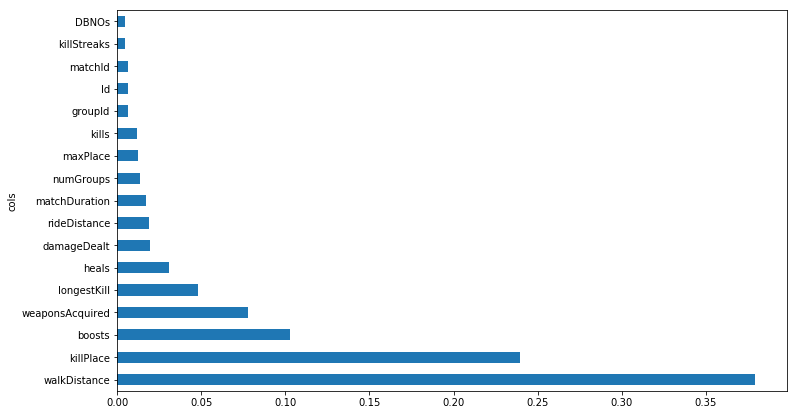

In [22]:
fi = rf_feat_importance(m2, df_keep)
plot_fi(fi);

### One-hot Encoding 

We will do one-hot encoding for the type of matches. 

In [25]:
# One hot encode matchType
train = pd.get_dummies(train, columns=['matchType'])

In [26]:
# Take a look at the encoding
matchType_encoding = train.filter(regex='matchType')
matchType_encoding.head()

,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


There are a lot of groupId's and matchId's so one-hot encoding them is computational suicide. We will turn them into category codes. That way we can still benefit from correlations between groups and matches in our Random Forest algorithm.

In [28]:
# Turn groupId and match Id into categorical types
train['groupId'] = train['groupId'].astype('category')
train['matchId'] = train['matchId'].astype('category')

# Get category coding for groupId and matchID
train['groupId_cat'] = train['groupId'].cat.codes
train['matchId_cat'] = train['matchId'].cat.codes

# Get rid of old columns
train.drop(columns=['groupId', 'matchId'], inplace=True)

# Lets take a look at our newly created features
train[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,613774,30085
1,827822,32751
2,843520,3143
3,1340461,45260
4,1757848,20531


In [29]:
m3 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features= 'sqrt',
                          n_jobs=-1, oob_score=True)
%time m3.fit(X_train, y_train)
print_score(m3)

CPU times: user 1min 6s, sys: 741 ms, total: 1min 7s
Wall time: 19.6 s
['mae train: ', 0.0381456386635948, 'mae val: ', 0.062467686518981276, 'R square train:', 0.9679865599585478, 'R square val:', 0.917428790655487, 0.9144738844261228]


However, it seems that there are not much changes to our score. 

## Removing Redundant Features

In [30]:
from scipy.cluster import hierarchy as hc

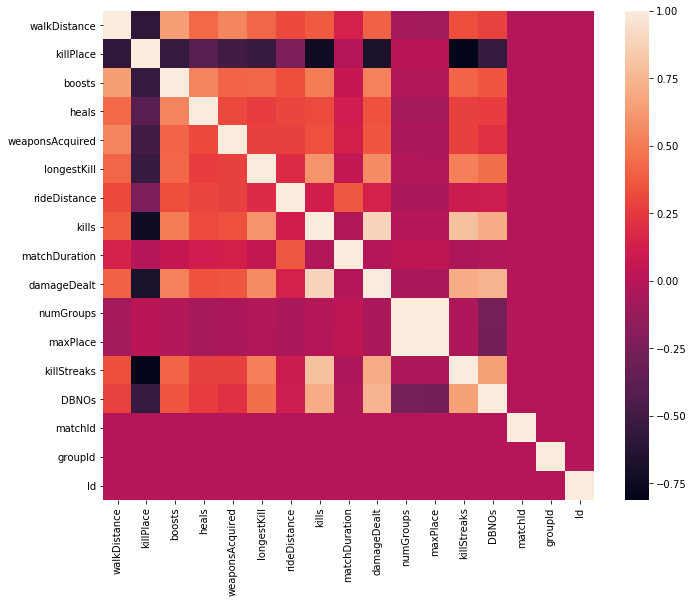

In [33]:
# Correlation heatmap
corr = df_keep.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Create heatmap
heatmap = sns.heatmap(corr)

In [34]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [47]:
get_oob(df_keep)

/Users/chanmunfai/opt/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.9178724239891672

In [48]:
for c in ('numGroups', 'maxPlace', 'kills', 'damageDealt', 'killStreaks'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

numGroups 0.9149688647516137
maxPlace 0.9164474528299978


/Users/chanmunfai/opt/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


kills 0.911933603620311
damageDealt 0.9176406095360136
killStreaks 0.9172731785295164


#### Drop maxPlace and damageDealt

It seems that we can drop 'maxPlace' and 'damageDealt' without drastically affecting the OOB score. 

In [49]:
to_drop = ['maxPlace', 'damageDealt']
get_oob(df_keep.drop(to_drop, axis=1))

/Users/chanmunfai/opt/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.916770433024916

In [60]:
df_keep2 = df_keep.drop(to_drop, axis =1).copy()

In [66]:
X_train, X_valid = split_vals(df_keep2, n_trn)

In [67]:
m4 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features= 'sqrt',
                          n_jobs=-1, oob_score=True)
%time m4.fit(X_train, y_train)
print_score(m4)

CPU times: user 54.8 s, sys: 580 ms, total: 55.4 s
Wall time: 16.2 s
['mae train: ', 0.04129418013817634, 'mae val: ', 0.06406539292281578, 'R square train:', 0.9632264278059723, 'R square val:', 0.9143927817869999, 0.9108246134435621]


It seems that the validation score has decreased instead. 

#### Drop MaxPlace

In [68]:
to_drop = ['maxPlace']
df_keep2 = df_keep.drop(to_drop, axis =1).copy()
X_train, X_valid = split_vals(df_keep2, n_trn)

In [69]:
m5 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features= 'sqrt',
                          n_jobs=-1, oob_score=True)
%time m5.fit(X_train, y_train)
print_score(m5)

CPU times: user 1min 8s, sys: 622 ms, total: 1min 8s
Wall time: 19.8 s
['mae train: ', 0.0386317297034168, 'mae val: ', 0.06338831917100907, 'R square train:', 0.9673454769206595, 'R square val:', 0.9158621637376805, 0.9127009913465015]


Here, the validation score also fell but by less. 

## Partial Dependence 

In [65]:
from pdpbox import pdp
from plotnine import *

In [80]:
!pip install scikit-misc

     |████████████████████████████████| 10.8 MB 477 kB/s eta 0:00:01


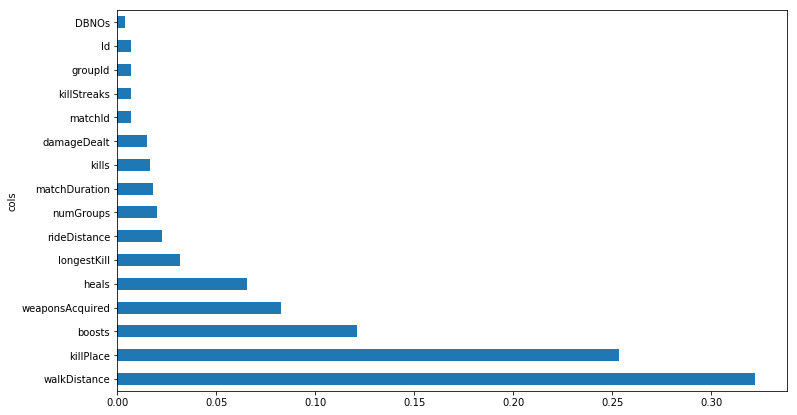

In [72]:
plot_fi(rf_feat_importance(m5, df_keep2)[:20]);

#### Exploring walkDistance 

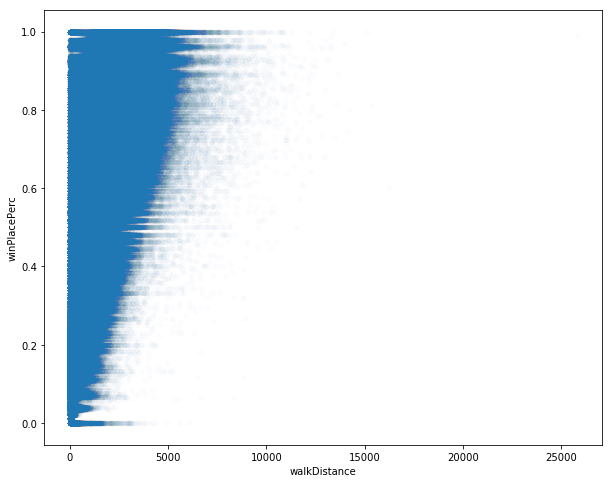

In [76]:
train.plot('walkDistance', 'winPlacePerc', 'scatter', alpha=0.01, figsize=(10,8));

#### Removing Hackers who do not move

Here, we see that there are players with 0 walkDistance and yet they won the game. This does not seem right. We can combine this with rideDistance and swimDistance to confirm that they are not moving. These may be potential hackers. 

Random Forest does not do well with outliers, so we removed these hackers. 

In [114]:
# Create feature totalDistance
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']

# Create feature killsWithoutMoving
train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))

In [118]:
display(train[train['killsWithoutMoving'] == True].shape)

(1535, 46)

In [121]:
train[train['killsWithoutMoving'] == True].head()

,Id,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,groupId_cat,matchId_cat,totalDistance,killsWithoutMoving
1824,b538d514ef2476,0,0,593.0,0,0,3,18,0,6,...,0,1,0,0,0,0,116842,10020,0.0,True
6673,6d3a61da07b7cb,2,0,346.6,0,0,6,33,0,3,...,0,1,0,0,0,0,360975,26930,0.0,True
11892,550398a8f33db7,2,0,1750.0,0,4,5,3,0,20,...,0,0,0,0,0,0,1551571,41012,0.0,True
14631,58d690ee461e9d,0,0,157.8,0,0,0,69,1000,1,...,0,1,0,0,0,0,1855648,41115,0.0,True
15591,49b61fc963d632,0,0,100.0,0,1,0,37,0,1,...,0,1,0,0,0,0,122135,26930,0.0,True


In [122]:
train.drop(train[train['killsWithoutMoving'] == True].index, inplace=True)

In [106]:
x_all = get_sample(df_keep2, 500)

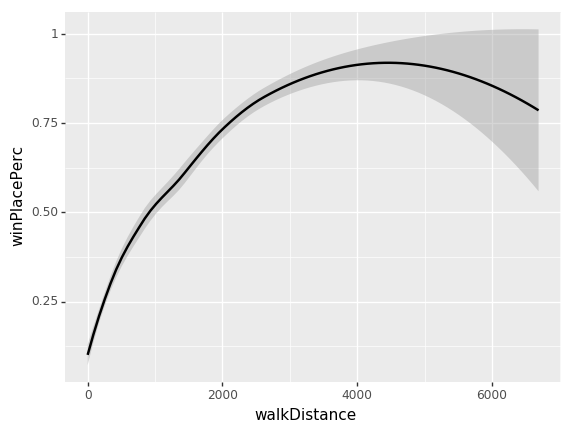

<ggplot: (-9223372029656022724)>

In [81]:
ggplot(x_all, aes('walkDistance', 'winPlacePerc'))+stat_smooth(se=True, method='loess')

In [107]:
x_all.drop(['Id'], axis = 1, inplace = True)

In [108]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m4, x_all, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

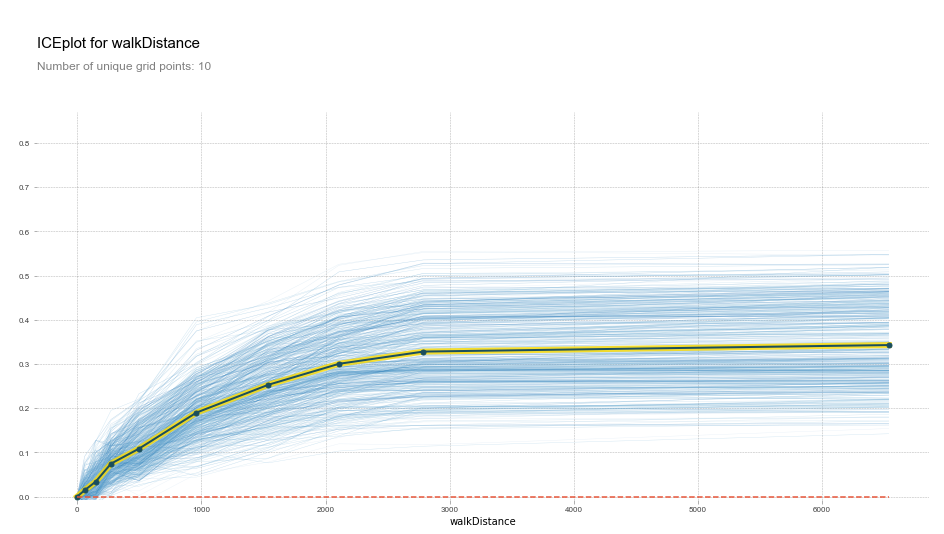

In [110]:
plot_pdp('walkDistance')

#### Exploring KillPlace 

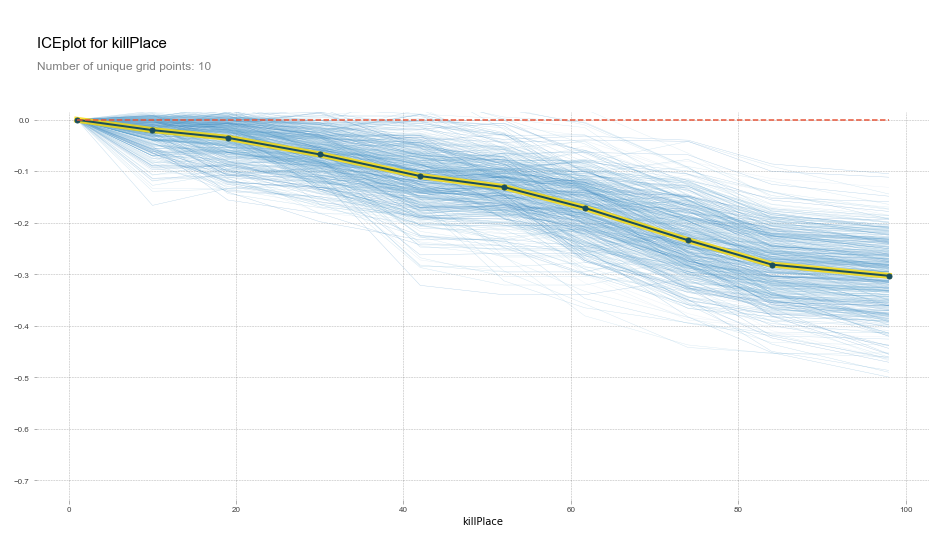

In [112]:
plot_pdp('killPlace')

killPlace is the ranking in the match of number of enemy players killed.

More simply, it is the ranking in the number of players a person kills, and the higher the number, the less you kill. 

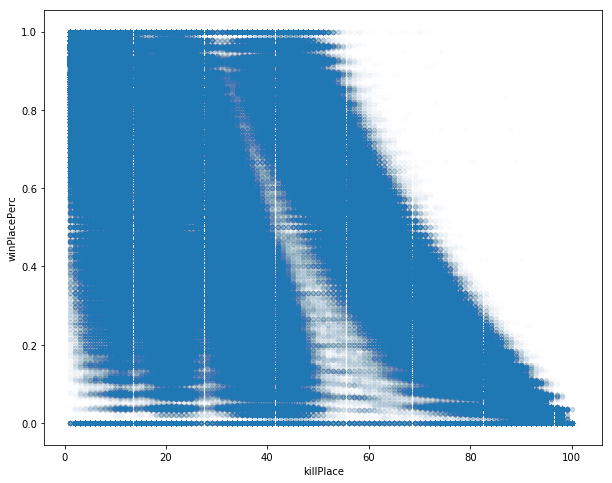

In [113]:
train.plot('killPlace', 'winPlacePerc', 'scatter', alpha=0.01, figsize=(10,8));

In [125]:
train.dtypes

Id                             object
assists                         int64
boosts                          int64
damageDealt                   float64
DBNOs                           int64
headshotKills                   int64
heals                           int64
killPlace                       int64
killPoints                      int64
kills                           int64
killStreaks                     int64
longestKill                   float64
matchDuration                   int64
maxPlace                        int64
numGroups                       int64
rankPoints                      int64
revives                         int64
rideDistance                  float64
roadKills                       int64
swimDistance                  float64
teamKills                       int64
vehicleDestroys                 int64
walkDistance                  float64
weaponsAcquired                 int64
winPoints                       int64
winPlacePerc                  float64
matchType_cr

## Outlier Detection 

Already, we have removed players who killed without moving at all. Now, we are going to remove other types of players whose behaviour are abnormal. 

#### VehicleDestroy

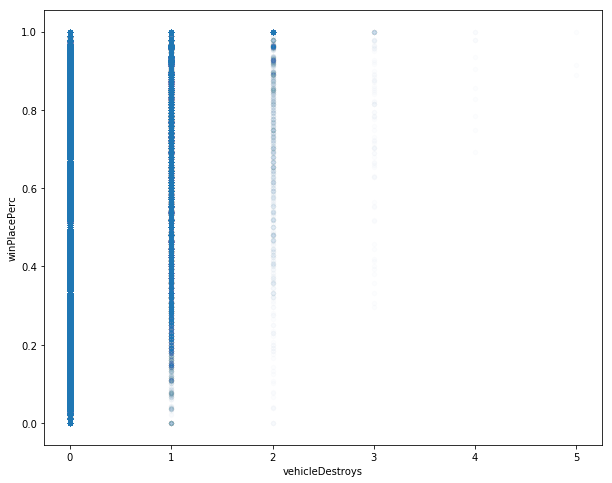

In [126]:
train.plot('vehicleDestroys', 'winPlacePerc', 'scatter', alpha=0.01, figsize=(10,8));

In [128]:
train[train['vehicleDestroys'] > 3].head()

,Id,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,groupId_cat,matchId_cat,totalDistance,killsWithoutMoving
72060,f263e2eaabf436,1,3,262.9,1,0,5,26,0,1,...,0,0,0,0,1,0,683962,16978,4924.7000,False
194647,66726573019dd2,0,4,380.0,0,0,1,8,0,3,...,0,0,0,1,0,0,765954,4023,4379.3175,False
258180,a6faf5c20db1d3,1,0,470.4,2,0,0,1,0,7,...,0,0,0,0,0,0,1331171,28874,4781.0000,False
1201437,54bcb6550134e1,2,5,129.6,2,0,3,52,0,0,...,0,0,0,0,0,1,1642445,29658,8894.0000,False
2790701,6bc55a36a4b723,0,5,337.9,3,0,11,8,1298,3,...,0,0,0,0,0,1,1409132,24066,6366.0000,False


#### weaponsAcquired

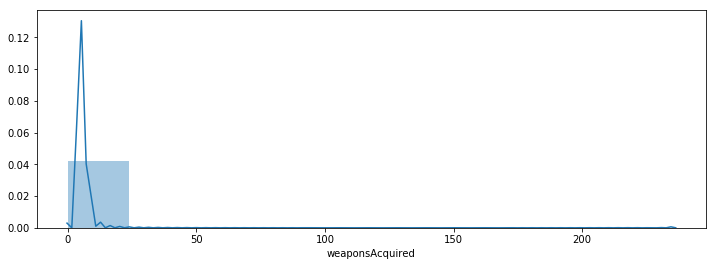

In [134]:
plt.figure(figsize=(12,4))
sns.distplot(train['weaponsAcquired'], bins=10)
plt.show()

In [141]:
train[train['weaponsAcquired'] > 50].head()

,Id,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,groupId_cat,matchId_cat,totalDistance,killsWithoutMoving


In [139]:
train.drop(train[train['weaponsAcquired'] > 50].index, inplace=True)

We removed players with weaponsAcquired > 50. 

#### Revives 

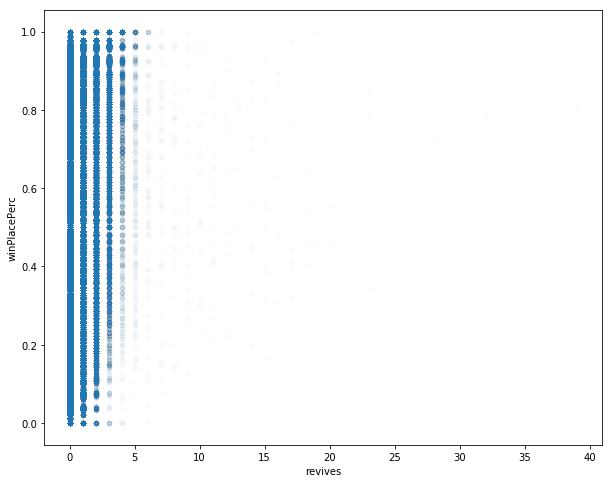

In [144]:
train.plot('revives', 'winPlacePerc', 'scatter', alpha=0.01, figsize=(10,8));

In [149]:
train[train['revives'] > 15].head()

,Id,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,groupId_cat,matchId_cat,totalDistance,killsWithoutMoving


In [148]:
train.drop(train[train['revives'] > 15].index, inplace=True)

#### Heals 

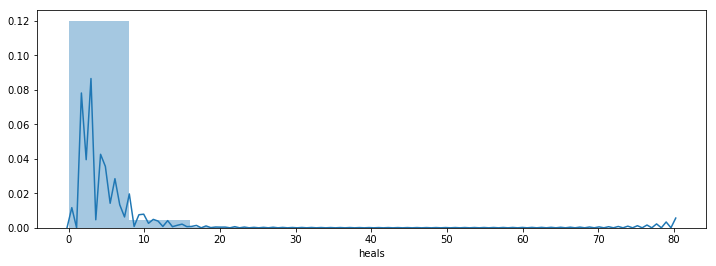

In [151]:
plt.figure(figsize=(12,4))
sns.distplot(train['heals'], bins=10)
plt.show()

In [165]:
train['heals'].describe([.5, .95, .99, .999])

count    4.445250e+06
mean     1.369853e+00
std      2.679519e+00
min      0.000000e+00
50%      0.000000e+00
95%      7.000000e+00
99%      1.200000e+01
99.9%    2.200000e+01
max      8.000000e+01
Name: heals, dtype: float64

In [166]:
train.drop(train[train['heals'] > 22].index, inplace=True)

#### DBNOs 
Number of enemy players knocked down 

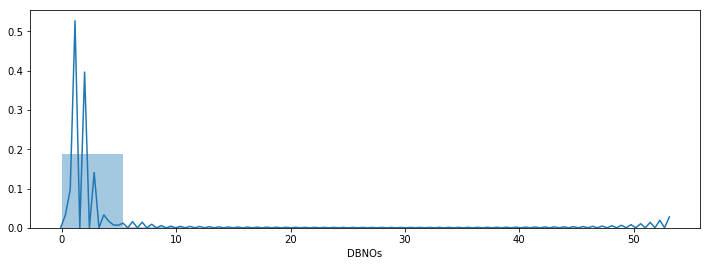

In [168]:
plt.figure(figsize=(12,4))
sns.distplot(train['DBNOs'], bins=10)
plt.show()

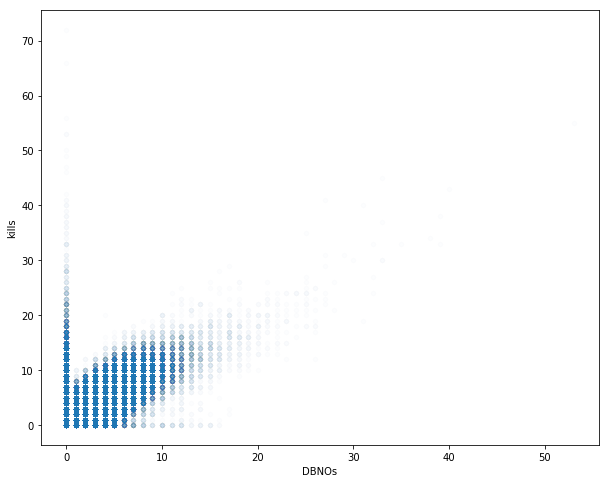

In [169]:
train.plot('DBNOs', 'kills', 'scatter', alpha=0.01, figsize=(10,8));

In [191]:
train['easykill'] = ((train['kills'] > 5) & (train['DBNOs'] == 0) & ((train['matchType_squad'] == 1)))

There does not seem to a huge problem here. 

In [227]:
train.drop(['Id'], axis =1, inplace=True)

In [ ]:
train.drop(['easykill'], axis =1, inplace=True)

In [233]:
train.drop(['Unnamed: 0'], axis =1, inplace=True)

In [229]:
train.reset_index();

In [238]:
train.to_csv('pubg_train_clean.csv')

In [237]:
train.shape

(4441677, 45)